# K-mean clustering

## Imports:

In [1]:
# import pytz
# import matplotlib.ticker as mpticker
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import finnhub
import matplotlib.dates as mpl_dates
import numpy as np
from datetime import * 

## Access stock data

In [2]:
# Setup client
finnhub_client = finnhub.Client(api_key = "bt3efpf48v6tfcs816eg")

# Stock candles
ticker = 'AAPL'
start_time = int(datetime(2021, 5, 21, 0, 0).replace(tzinfo = timezone.utc).timestamp())
end_time = int(datetime(2021, 6, 21, 0, 0).replace(tzinfo = timezone.utc).timestamp())
res = finnhub_client.stock_candles(ticker, 'D', start_time, end_time)

stock = pd.DataFrame(res)
stock = stock.rename(columns = {'t':'Date', 'o':'Open', 'h':'High', 'l':'Low', 'c':'Close', 's':'status', 'v':'volumn'})
stock['Date'] = pd.to_datetime(stock['Date'], unit = 's')
stock = stock.set_index('Date')

## Define functions

In [3]:
def get_optimum_clusters(df, saturation_point = 0.05):
    '''
    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers
    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []
    labels = []

    size = min(8, df.shape[0])
    for i in range(1, size):
        # kmeans = KMeans(n_clusters = i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans = KMeans(n_clusters = i, init='random', max_iter=300, n_init=10)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_) # Sum of squared distances of samples to their Closest cluster center
        k_models.append(kmeans)
        labels.append(kmeans.labels_)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]
    labels = labels[optimum_k]

    return (optimum_clusters.cluster_centers_, labels)

## Find R&S and Plot

In [4]:
Lows = pd.DataFrame(data = stock, index = stock.index, columns = ['Low'])
Highs = pd.DataFrame(data = stock, index = stock.index, columns = ['High'])
Low_centers, low_labels = get_optimum_clusters(Lows)
High_centers, high_labels = get_optimum_clusters(Highs)
Low_centers = Low_centers.flatten()
High_centers = High_centers.flatten()
Lows['labels'] = pd.Series(low_labels, index = Lows.index)
Highs['labels'] = pd.Series(high_labels, index = Highs.index)
res = [max(Highs.loc[Highs.labels == i, 'High']) for i in np.unique(high_labels)]
sup = [min(Lows.loc[Lows.labels == i, 'Low']) for i in np.unique(low_labels)]

In [5]:
# stock['Datetime'] = pd.to_datetime(stock.index)
last_day = stock.iloc[-1].to_frame().T

not_pivots = list(last_day.columns)

last_day['Pivot'] = (last_day['High'] + last_day['Low'] + last_day['Close'])/3
last_day['R1'] = 2*last_day['Pivot'] - last_day['Low']
last_day['S1'] = 2*last_day['Pivot'] - last_day['High']
last_day['R2'] = last_day['Pivot'] + (last_day['High'] - last_day['Low'])
last_day['S2'] = last_day['Pivot'] - (last_day['High'] - last_day['Low'])
last_day['R3'] = last_day['Pivot'] + 2*(last_day['High'] - last_day['Low'])
last_day['S3'] = last_day['Pivot'] - 2*(last_day['High'] - last_day['Low'])

pivots = [n for n in last_day.columns if n not in not_pivots]

pcols = ['green', 'blue', 'blue', 'red', 'red', 'black', 'black']

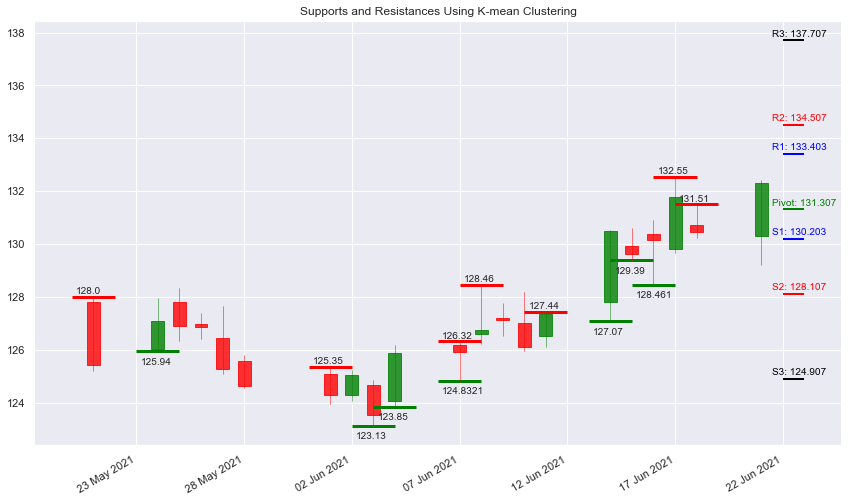

In [39]:
import seaborn as sns

sns.set_theme()
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)
fig, ax = plt.subplots()

stock['Date'] = pd.to_datetime(stock.index)
stock['Date'] = stock['Date'].apply(mpl_dates.date2num)
stock = stock.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

candlestick_ohlc(ax, stock.values, width=0.6,\
                 colorup='green', colordown='red', alpha=0.8)
date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()

Highs['Date'] = pd.to_datetime(Highs.index)
Highs['Date'] = Highs['Date'].apply(mpl_dates.date2num)
min_date_high = min(Highs.Date)
max_date_high = max(Highs.Date)
for i in range(len(res)):
    mu = Highs[Highs.High == res[i]].Date.values[0]
    plt.hlines(res[i], xmin = mu - 1, xmax = min(mu + 1, max_date_high), color = 'red', linewidth = 3)
    plt.text(x = mu - 0.8, y = res[i] + 0.1, s = str(res[i]), size = 10)
    
Lows['Date'] = pd.to_datetime(Lows.index)
Lows['Date'] = Lows['Date'].apply(mpl_dates.date2num)
min_date_low = min(Lows.Date)
max_date_low = max(Lows.Date)
for i in range(len(sup)):
    mu = Lows[Lows.Low == sup[i]].Date.values[0]
    plt.hlines(sup[i], xmin = max(min_date_low, mu - 1), xmax = min(mu + 1, max_date_low),\ 
               color = 'green', linewidth = 3)
    plt.text(x = mu - 0.8, y = sup[i] - 0.5, s = str(sup[i]), size = 10)

for i, col in enumerate(pivots):
    plt.hlines(last_day[col].iloc[-1], xmin = stock.Date[-1] + 1, xmax = stock.Date[-1] + 2,\
               color = pcols[i], linewidth = 2)
    plt.text(x = stock.Date[-1] + 0.5, y = last_day[col].iloc[-1] + 0.15,\
             s = col + ': ' + str(round(last_day[col].iloc[-1], 3)), color = pcols[i], size = 10)
    
# for i, col in enumerate(pivots):
#     plt.hlines(last_day[col].iloc[-1], xmin = stock.Date[-1] + 1, xmax = stock.Date[-1] + 2,\
#                color = pcols[i], linewidth = 2)
#     plt.text(x = stock.Date[-1] + 3, y = last_day[col].iloc[-1],\
#              s = col + ': ' + str(round(last_day[col].iloc[-1], 3)), color = pcols[i])
    
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.title('Supports and Resistances Using K-mean Clustering')
plt.show()

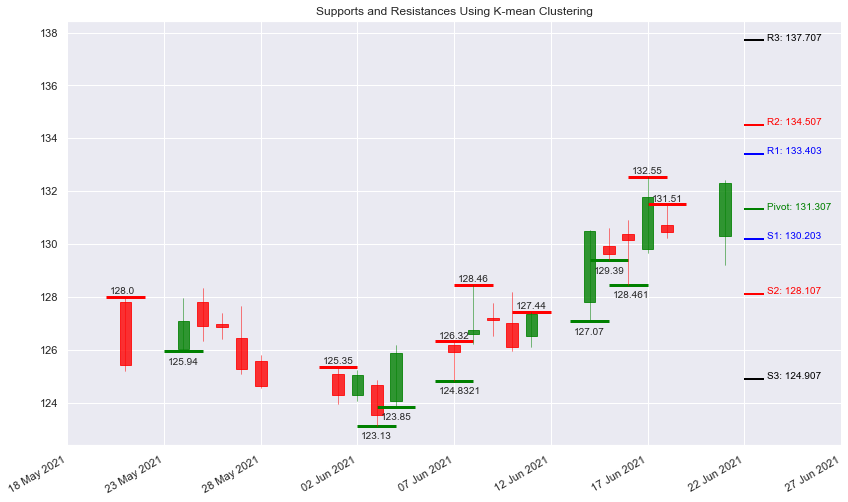

In [43]:
import seaborn as sns

sns.set_theme()
plt.rcParams['figure.figsize'] = [12, 7]
plt.rc('font', size=14)
fig, ax = plt.subplots()

stock['Date'] = pd.to_datetime(stock.index)
stock['Date'] = stock['Date'].apply(mpl_dates.date2num)
stock = stock.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]

ax.set_xlim([stock.Date[0] - 3, stock.Date[-1] + 6])

candlestick_ohlc(ax, stock.values, width=0.6,\
                 colorup='green', colordown='red', alpha=0.8)
date_format = mpl_dates.DateFormatter('%d %b %Y')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()
fig.tight_layout()

Highs['Date'] = pd.to_datetime(Highs.index)
Highs['Date'] = Highs['Date'].apply(mpl_dates.date2num)
min_date_high = min(Highs.Date)
max_date_high = max(Highs.Date)
for i in range(len(res)):
    mu = Highs[Highs.High == res[i]].Date.values[0]
    plt.hlines(res[i], xmin = mu - 1, xmax = min(mu + 1, max_date_high), color = 'red', linewidth = 3)
    plt.text(x = mu - 0.8, y = res[i] + 0.1, s = str(res[i]), size = 10)
    
Lows['Date'] = pd.to_datetime(Lows.index)
Lows['Date'] = Lows['Date'].apply(mpl_dates.date2num)
min_date_low = min(Lows.Date)
max_date_low = max(Lows.Date)
for i in range(len(sup)):
    mu = Lows[Lows.Low == sup[i]].Date.values[0]
    plt.hlines(sup[i], xmin = max(min_date_low, mu - 1), xmax = min(mu + 1, max_date_low), color = 'green', linewidth = 3)
    plt.text(x = mu - 0.8, y = sup[i] - 0.5, s = str(sup[i]), size = 10)

# for i, col in enumerate(pivots):
#     plt.hlines(last_day[col].iloc[-1], xmin = stock.Date[-1] + 1, xmax = stock.Date[-1] + 2,\
#                color = pcols[i], linewidth = 2)
#     plt.text(x = stock.Date[-1] + 0.5, y = last_day[col].iloc[-1] + 0.15,\
#              s = col + ': ' + str(round(last_day[col].iloc[-1], 3)), color = pcols[i], size = 10)
    
for i, col in enumerate(pivots):
    plt.hlines(last_day[col].iloc[-1], xmin = stock.Date[-1] + 1, xmax = stock.Date[-1] + 2,\
               color = pcols[i], linewidth = 2)
    plt.text(x = stock.Date[-1] + 2.2, y = last_day[col].iloc[-1],\
             s = col + ': ' + str(round(last_day[col].iloc[-1], 3)), color = pcols[i], size = 10)
    
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
plt.title('Supports and Resistances Using K-mean Clustering')
plt.show()